
Datset from; https://sysomics.com/Download/ "Secreted protein database(SPD)"


In [ ]:
import pandas as pd
import random
from tqdm import tqdm
from joblib import Parallel, delayed
from Bio import ExPASy
from Bio import SwissProt
import requests
from requests.exceptions import RequestException
import time

def fetch_sequence(uniprot_id, verbose=False):
    """Fetch protein sequence from UniProt in FASTA format."""
    try:
        if verbose:
            print(f"Fetching sequence for {uniprot_id}...")
        url = f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta"
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        sequence = ''.join(response.text.splitlines()[1:])
        return sequence
    except RequestException as e:
        if verbose:
            print(f"Request failed for {uniprot_id}: {e}")
        return None

def get_human_proteins_from_csv(csv_path, max_proteins=None):
    """Load human proteins from CSV, optionally limiting to max_proteins."""
    print(f"Loading human proteins from {csv_path}...")
    df = pd.read_csv(csv_path)
    
    # Extract only the first protein ID from each entry
    human_proteins = df[(df['Species'] == 'HUMAN') & (df["Ranking"] == "rank3")]['AccessionNumberorgiNumber'].tolist()
    human_proteins = [str(pid).split()[0] for pid in human_proteins]  # Take first ID only
    
    if max_proteins is not None and max_proteins < len(human_proteins):
        print(f"Randomly sampling {max_proteins} from {len(human_proteins)} human proteins...")
        human_proteins = random.sample(human_proteins, max_proteins)
        print(f"Selected {len(human_proteins)} human proteins from CSV.")
    else:
        print(f"Found {len(human_proteins)} human proteins in CSV.")
    
    return human_proteins

def get_all_reviewed_proteins(max_fetch=50000):
    """Fetch a large pool of reviewed protein IDs to sample from."""
    print(f"Building pool of reviewed proteins (fetching up to {max_fetch})...")
    all_proteins = []
    batch_size = 500
    
    for offset in tqdm(range(0, max_fetch, batch_size), desc="Fetching protein pool"):
        try:
            url = f"https://rest.uniprot.org/uniprotkb/search?query=reviewed:true&format=json&size={batch_size}&offset={offset}&fields=accession"
            response = requests.get(url, timeout=15)
            response.raise_for_status()
            data = response.json()
            results = data.get("results", [])
            
            if not results:
                break
                
            for protein in results:
                all_proteins.append(protein["primaryAccession"])
                
        except Exception as e:
            print(f"Error at offset {offset}: {e}")
            break
    
    print(f"Collected {len(all_proteins)} reviewed proteins in pool.")
    return all_proteins

def select_random_human_proteins(num_proteins, use_large_pool=True):
    """
    Select random proteins from UniProt.
    
    Args:
        num_proteins: Number of random proteins to select
        use_large_pool: If True, fetch a large pool first then sample randomly (recommended)
                       If False, use the faster but less random offset method
    """
    print(f"Selecting {num_proteins} random proteins from UniProt...")
    
    if use_large_pool:
        # Method 1: Fetch large pool, then random sample (truly random)
        pool_size = min(50000, num_proteins * 500)  # Fetch 50x more than needed
        protein_pool = get_all_reviewed_proteins(max_fetch=pool_size)
        
        if len(protein_pool) < num_proteins:
            print(f"Warning: Only found {len(protein_pool)} proteins, using all of them")
            return protein_pool
        
        selected = random.sample(protein_pool, num_proteins)
        print(f"Randomly sampled {len(selected)} proteins from pool of {len(protein_pool)}")
        return selected
    else:
        # Method 2: Use random offsets (faster but less random)
        print("Using fast offset-based selection (less random)...")
        all_proteins = []
        seen = set()
        
        # Generate random offsets
        max_offset = 500000  # Approximate size of SwissProt
        random_offsets = random.sample(range(0, max_offset, 500), (num_proteins // 500) + 3)
        
        def fetch_batch_at_offset(offset):
            try:
                url = f"https://rest.uniprot.org/uniprotkb/search?query=reviewed:true&format=json&size=500&offset={offset}&fields=accession"
                response = requests.get(url, timeout=15)
                response.raise_for_status()
                data = response.json()
                results = data.get("results", [])
                return [protein["primaryAccession"] for protein in results]
            except:
                return []
        
        # Fetch batches in parallel
        batch_results = Parallel(n_jobs=4)(
            delayed(fetch_batch_at_offset)(offset) 
            for offset in tqdm(random_offsets, desc="Fetching random batches")
        )
        
        # Deduplicate
        for batch in batch_results:
            for pid in batch:
                if pid not in seen:
                    seen.add(pid)
                    all_proteins.append(pid)
        
        # Shuffle and select
        random.shuffle(all_proteins)
        selected = all_proteins[:num_proteins]
        print(f"Selected {len(selected)} proteins using random offsets")
        return selected

def create_protein_dataframe(csf_proteins, random_proteins, n_jobs=-1):
    """Create a DataFrame with protein sequences and labels."""
    print(f"Fetching sequences for {len(csf_proteins) + len(random_proteins)} proteins using {n_jobs if n_jobs > 0 else 'all'} cores...")
    all_proteins = csf_proteins + random_proteins
    
    # Parallel fetch with progress bar
    sequences = Parallel(n_jobs=n_jobs, backend='threading')(
        delayed(fetch_sequence)(pid, verbose=False) 
        for pid in tqdm(all_proteins, desc="Fetching sequences")
    )
    
    # Filter out failed requests
    valid_entries = [(pid, seq) for pid, seq in zip(all_proteins, sequences) if seq]
    failed = len(all_proteins) - len(valid_entries)
    if failed > 0:
        print(f"Warning: {failed} sequences failed to fetch")
    
    all_proteins, sequences = zip(*valid_entries) if valid_entries else ([], [])
    
    df = pd.DataFrame({
        'protein': all_proteins,
        'sequence': sequences,
        'label': [1 if pid in csf_proteins else 0 for pid in all_proteins]
    })
    print(f"Protein DataFrame created with {len(df)} proteins.")
    return df

def assign_set(label):
    """Assign train/test/validation set."""
    r = random.random()
    if r < 0.7:
        return 'train'
    elif r < 0.85:
        return 'validation'
    else:
        return 'test'

def main(csv_path, max_secreted_proteins=None, n_jobs_fetch=-1, truly_random=True):
    """
    Main function to process proteins.
    
    Args:
        csv_path: Path to the CSV file with secreted proteins
        max_secreted_proteins: Maximum number of secreted proteins to use (None = use all)
        n_jobs_fetch: Number of parallel jobs for sequence fetching (-1 = all cores)
        truly_random: If True, fetch large pool then sample (slower but truly random)
                     If False, use random offsets (faster but less random)
    """
    csf_proteins = get_human_proteins_from_csv(csv_path, max_proteins=max_secreted_proteins)
    num_csf = len(csf_proteins)
    print(f"Using {num_csf} secreted proteins")
    random_proteins = select_random_human_proteins(num_csf, use_large_pool=truly_random)
    df = create_protein_dataframe(csf_proteins, random_proteins, n_jobs=n_jobs_fetch)
    df['set'] = df['label'].apply(assign_set)
    print("Finished processing proteins.")
    return df

# Usage
csv_path = "/home/gdallagl/myworkdir/ESMSec/data/protein/SPD Database.csv"
print("Starting protein processing pipeline...")

# For truly random proteins (recommended but slower)
df = main(csv_path, max_secreted_proteins=500, truly_random=False)

# OR for faster but less random (uses random offsets)
# df = main(csv_path, max_secreted_proteins=1000, truly_random=False)

print(df.head())
print(f"Dataset shape: {df.shape}")
print(f"Label distribution:\n{df['label'].value_counts()}")
print("Pipeline completed.")

Starting protein processing pipeline...
Loading human proteins from /home/gdallagl/myworkdir/ESMSec/data/protein/SPD Database.csv...
Randomly sampling 500 from 5670 human proteins...
Selected 500 human proteins from CSV.
Using 500 secreted proteins
Selecting 500 random proteins from UniProt...
Using fast offset-based selection (less random)...



Fetching random batches: 100%|██████████| 4/4 [00:00<00:00, 350.38it/s]

Selected 500 proteins using random offsets
Fetching sequences for 1000 proteins using all cores...


































Fetching sequences:  45%|████▍     | 447/1000 [05:24<06:41,  1.38it/s]





























































































Fetching sequences: 100%|██████████| 1000/1000 [05:06<00:00,  3.26it/s]


Protein DataFrame created with 678 proteins.
Finished processing proteins.
  protein                                           sequence  label    set
0  P03971  MRDLPLTSLALVLSALGALLGTEALRAEEPAVGTSGLIFREDLDWP...      1   test
1  Q9BTV7  MAAAAAGGAPGPAPGPAGPPPPAAPTSAARAPPQALRRRGDSRRRQ...      1  train
2  Q6UY30  MSERHGPSPQSVLLSLWFVLTLTPFLFLTLLSCMEHTAPAPFQSAW...      1   test
3  Q16557  MGPLSAPPCTQRITWKGLLLTALLLNFWNLPTTAQVTIEAEPTKVS...      1  train
4  Q5JP59  MAPALLLIPAALASFILAFGTGVEFVRFTSLRPLLGGIPESGGPDA...      1  train
Dataset shape: (678, 4)
Label distribution:
label
0    495
1    183
Name: count, dtype: int64
Pipeline completed.


In [7]:
display(df.head())


,protein,sequence,label,set
0,P03971,MRDLPLTSLALVLSALGALLGTEALRAEEPAVGTSGLIFREDLDWP...,1,test
1,Q9BTV7,MAAAAAGGAPGPAPGPAGPPPPAAPTSAARAPPQALRRRGDSRRRQ...,1,train
2,Q6UY30,MSERHGPSPQSVLLSLWFVLTLTPFLFLTLLSCMEHTAPAPFQSAW...,1,test
3,Q16557,MGPLSAPPCTQRITWKGLLLTALLLNFWNLPTTAQVTIEAEPTKVS...,1,train
4,Q5JP59,MAPALLLIPAALASFILAFGTGVEFVRFTSLRPLLGGIPESGGPDA...,1,train


In [8]:
df.to_csv("/home/gdallagl/myworkdir/ESMSec/data/protein/SPD_processed.csv", index=False)

#  CYTO Vs SECRETED

In [26]:
import requests
import pandas as pd
from io import StringIO
import random
import time

def _normalize_uniprot_tsv_df(df):
    """
    Given a DataFrame parsed from UniProt TSV, detect accession and sequence columns,
    rename them to 'protein' and 'sequence', and return a DataFrame with those columns
    plus any of protein_name/gene_names/organism_name if present.
    """
    # Lowercase column map for detection
    col_lower = {c: c.lower() for c in df.columns}

    # Find accession column (common names: Entry, Entry name, accession, UniProtKB-ID)
    accession_col = None
    for name in df.columns:
        nl = name.lower()
        if nl in ("entry", "accession", "primary accession", "entry name", "entry_id"):
            accession_col = name
            break
    if accession_col is None:
        # fallback: any column that contains 'access' or 'entry'
        for name in df.columns:
            if "access" in name.lower() or "entry" in name.lower():
                accession_col = name
                break

    # Find sequence column
    sequence_col = None
    for name in df.columns:
        if "sequence" in name.lower():
            sequence_col = name
            break

    # Optional extras
    protein_name_col = None
    gene_names_col = None
    organism_col = None
    for name in df.columns:
        nl = name.lower()
        if "protein name" in nl or nl == "protein names" or "protein" == nl:
            protein_name_col = name
        if "gene name" in nl or "gene names" in nl or nl == "genes":
            gene_names_col = name
        if "organism" in nl:
            organism_col = name

    missing = []
    if accession_col is None:
        missing.append("accession/Entry")
    if sequence_col is None:
        missing.append("sequence")
    if missing:
        raise KeyError(
            "Could not detect expected columns in UniProt TSV response. "
            f"Missing: {', '.join(missing)}. Available columns: {list(df.columns)}"
        )

    # build standardized DataFrame
    cols = {}
    cols['protein'] = df[accession_col].astype(str)
    cols['sequence'] = df[sequence_col].astype(str)
    if protein_name_col:
        cols['protein_name'] = df[protein_name_col].astype(str)
    if gene_names_col:
        cols['gene_names'] = df[gene_names_col].astype(str)
    if organism_col:
        cols['organism_name'] = df[organism_col].astype(str)

    return pd.DataFrame(cols)


def fetch_proteins_with_sequence(keyword, n=10, organism="Homo sapiens", sleep_between_requests=0.2):
    """
    Fetch N proteins from UniProt with given keyword including sequences.
    Handles API limit (<=500 size) by batching. Automatically normalizes TSV columns.
    Returns a DataFrame with at least ['protein', 'sequence'].
    """
    base_url = "https://rest.uniprot.org/uniprotkb/search"
    batch_size = 500
    dfs = []

    # Build query once
    query = f'keyword:"{keyword}" AND organism_name:"{organism}"'

    for offset in range(0, n, batch_size):
        size = min(batch_size, n - offset)
        params = {
            "query": query,
            "format": "tsv",
            # request a set of useful fields; TSV header may vary so normalization will handle it
            "fields": "accession,protein_name,gene_names,organism_name,sequence",
            "size": size,
            "offset": offset
        }

        resp = requests.get(base_url, params=params, timeout=30)
        if resp.status_code != 200:
            raise Exception(f"UniProt request failed (status {resp.status_code}):\n{resp.text}")

        # parse TSV; some responses include an explanatory first line -> pandas can handle header row
        df_batch = pd.read_csv(StringIO(resp.text), sep="\t", dtype=str)
        if df_batch.empty:
            break

        # normalize and append
        df_norm = _normalize_uniprot_tsv_df(df_batch)
        dfs.append(df_norm)

        # be polite
        time.sleep(sleep_between_requests)

    if not dfs:
        return pd.DataFrame(columns=['protein','sequence'])

    df_all = pd.concat(dfs, ignore_index=True)

    # sometimes API returns duplicates across offsets; drop duplicates by accession
    df_all = df_all.drop_duplicates(subset='protein').reset_index(drop=True)

    # limit to requested n (in case API returned more)
    if len(df_all) > n:
        df_all = df_all.iloc[:n].reset_index(drop=True)

    return df_all


def assign_set(label):
    r = random.random()
    if r < 0.7:
        return 'train'
    elif r < 0.85:
        return 'validation'
    else:
        return 'test'


def create_protein_df(secreted_n=50, cytoplasm_n=50, organism="Homo sapiens"):
    # fetch secreted
    df_secreted = fetch_proteins_with_sequence("KW-0964", secreted_n, organism=organism)
    df_secreted['label'] = 1

    # fetch cytoplasmic
    df_cytoplasm = fetch_proteins_with_sequence("KW-0378", cytoplasm_n, organism=organism)
    df_cytoplasm['label'] = 0

    # ensure column presence
    for df in (df_secreted, df_cytoplasm):
        for col in ('protein','sequence'):
            if col not in df.columns:
                raise KeyError(f"Missing expected column '{col}' in fetched data. Available: {list(df.columns)}")

    # combine and keep desired columns
    df = pd.concat([
        df_secreted[['protein','sequence','label']],
        df_cytoplasm[['protein','sequence','label']]
    ], ignore_index=True)

    # assign dataset splits
    df['set'] = df['label'].apply(assign_set)
    return df


if __name__ == "__main__":
    # example
    N = 1000
    df = create_protein_df(secreted_n=N, cytoplasm_n=N)
    display(df.head())
    print("shape:", df.shape)
    print(df['label'].value_counts())
    print(df['set'].value_counts())


,protein,sequence,label,set
0,A0A0C5B5G6,MRWQEMGYIFYPRKLR,1,train
1,B2RUY7,MALHIHEACILLLVIPGLVTSAAISHEDYPADEGDQISSNDNLIFD...,1,train
2,O00300,MNNLLCCALVFLDISIKWTTQETFPPKYLHYDEETSHQLLCDKCPP...,1,validation
3,O00560,MSLYPSLEDLKVDKVIQAQTAFSANPANPAILSEASAPIPHDGNLY...,1,test
4,O00622,MSSRIARALALVVTLLHLTRLALSTCPAACHCPLEAPKCAPGVGLV...,1,test


shape: (1000, 4)
label
1    500
0    500
Name: count, dtype: int64
set
train         701
validation    153
test          146
Name: count, dtype: int64


<Axes: ylabel='Frequency'>

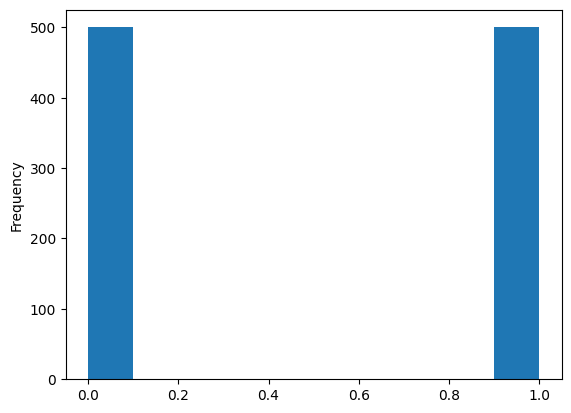

In [30]:
df.shape

df.label.plot(kind='hist')

In [ ]:
df.to_csv("/home/gdallagl/myworkdir/ESMSec/data/protein/cyto_sec_dataset.csv", index=False)

In [40]:
import requests
import pandas as pd
from io import StringIO
import random
import time

def _normalize_uniprot_tsv_df(df):
    """Normalize UniProt TSV column names to standard format."""
    accession_col = None
    sequence_col = None
    
    for name in df.columns:
        nl = name.lower()
        if accession_col is None and nl in ("entry", "accession", "primary accession", "entry name"):
            accession_col = name
        if sequence_col is None and "sequence" in nl:
            sequence_col = name
    
    if accession_col is None or sequence_col is None:
        raise KeyError(f"Missing required columns. Available: {list(df.columns)}")
    
    return pd.DataFrame({
        'protein': df[accession_col].astype(str),
        'sequence': df[sequence_col].astype(str)
    })

def fetch_proteins_with_pagination(keyword, n, organism="Homo sapiens", exclude=set()):
    """
    Fetch n unique proteins using pagination (multiple 500-result batches).
    Excludes proteins in the 'exclude' set.
    """
    base_url = "https://rest.uniprot.org/uniprotkb/search"
    query = f'keyword:"{keyword}" AND organism_name:"{organism}"'
    
    collected = []
    collected_ids = set()
    offset = 0
    batch_size = 500  # UniProt's max per request
    
    print(f"  Fetching proteins for keyword {keyword} (target: {n})...")
    
    while len(collected) < n:
        params = {
            "query": query,
            "format": "tsv",
            "fields": "accession,sequence",
            "size": batch_size,
            "offset": offset
        }
        
        try:
            resp = requests.get(base_url, params=params, timeout=30)
            
            if resp.status_code != 200:
                print(f"    Warning: Request failed with status {resp.status_code}")
                break
            
            df_batch = pd.read_csv(StringIO(resp.text), sep="\t", dtype=str)
            
            if df_batch.empty:
                print(f"    No more results at offset {offset}")
                break
            
            df_batch = _normalize_uniprot_tsv_df(df_batch)
            
            # Filter and collect unique proteins
            added_this_batch = 0
            for _, row in df_batch.iterrows():
                pid = row['protein']
                
                # Skip if already collected, excluded, or duplicate
                if pid in collected_ids or pid in exclude:
                    continue
                
                collected.append({'protein': pid, 'sequence': row['sequence']})
                collected_ids.add(pid)
                added_this_batch += 1
                
                if len(collected) >= n:
                    break
            
            print(f"    Offset {offset}: got {len(df_batch)} results, added {added_this_batch} unique (total: {len(collected)}/{n})")
            
            # If we got fewer results than batch_size, we've reached the end
            if len(df_batch) < batch_size:
                print(f"    Reached end of available results")
                break
            
            # If we added nothing new from a full batch, likely no more unique results
            if added_this_batch == 0 and len(df_batch) == batch_size:
                print(f"    No new unique proteins found, stopping")
                break
            
            offset += batch_size
            time.sleep(0.2)  # Be nice to the API
            
        except Exception as e:
            print(f"    Error at offset {offset}: {e}")
            break
    
    return pd.DataFrame(collected)

def create_protein_df_disjoint(secreted_n=1000, cytoplasm_n=1000, organism="Homo sapiens"):
    """
    Create a dataset with disjoint sets of secreted and cytoplasmic proteins.
    Uses pagination to fetch large numbers of proteins.
    """
    print(f"\n{'='*60}")
    print(f"Fetching {secreted_n} secreted + {cytoplasm_n} cytoplasmic proteins")
    print(f"{'='*60}\n")
    
    # 1) Fetch secreted proteins
    print(f"Step 1: Fetching secreted proteins (KW-0964)...")
    df_secreted = fetch_proteins_with_pagination("KW-0964", secreted_n, organism=organism)
    print(f"  ✓ Got {len(df_secreted)} secreted proteins.\n")
    
    # 2) Fetch cytoplasmic proteins, excluding secreted ones
    secreted_ids = set(df_secreted['protein'].tolist())
    print(f"Step 2: Fetching cytoplasmic proteins (KW-0378), excluding {len(secreted_ids)} secreted IDs...")
    df_cyt = fetch_proteins_with_pagination("KW-0378", cytoplasm_n, organism=organism, exclude=secreted_ids)
    print(f"  ✓ Got {len(df_cyt)} cytoplasmic proteins.\n")
    
    # Warn if we couldn't reach targets
    if len(df_secreted) < secreted_n:
        print(f"⚠ Warning: Only found {len(df_secreted)}/{secreted_n} unique secreted proteins.")
    if len(df_cyt) < cytoplasm_n:
        print(f"⚠ Warning: Only found {len(df_cyt)}/{cytoplasm_n} unique cytoplasmic proteins.")
    
    # Label classes
    df_secreted['label'] = 1  # secreted
    df_cyt['label'] = 0       # cytoplasmic
    
    # Combine
    df = pd.concat([
        df_secreted[['protein', 'sequence', 'label']],
        df_cyt[['protein', 'sequence', 'label']]
    ], ignore_index=True)
    
    # Assign train/validation/test splits (70/15/15)
    def assign_set(label):
        r = random.random()
        if r < 0.7:
            return 'train'
        elif r < 0.85:
            return 'validation'
        else:
            return 'test'
    
    df['set'] = df['label'].apply(lambda x: assign_set(x))
    
    return df

if __name__ == "__main__":
    random.seed(42)  # For reproducibility
    
    # Fetch dataset with 2000 proteins per class
    df = create_protein_df_disjoint(secreted_n=2000, cytoplasm_n=2000)
    
    print("\n" + "="*60)
    print("FINAL DATASET")
    print("="*60)
    print(f"Total rows: {len(df)}")
    print(f"\nClass distribution:")
    print(df['label'].value_counts().sort_index())
    print(f"\nSet distribution:")
    print(df['set'].value_counts())
    print(f"\nSample rows:")
    display(df.head(3))
    
    # Optionally save to CSV
    # df.to_csv('protein_dataset.csv', index=False)
    # print("\nDataset saved to 'protein_dataset.csv'")


Fetching 2000 secreted + 2000 cytoplasmic proteins

Step 1: Fetching secreted proteins (KW-0964)...
  Fetching proteins for keyword KW-0964 (target: 2000)...
    Offset 0: got 500 results, added 500 unique (total: 500/2000)
    Offset 500: got 500 results, added 0 unique (total: 500/2000)
    No new unique proteins found, stopping
  ✓ Got 500 secreted proteins.

Step 2: Fetching cytoplasmic proteins (KW-0378), excluding 500 secreted IDs...
  Fetching proteins for keyword KW-0378 (target: 2000)...
    Offset 0: got 500 results, added 416 unique (total: 416/2000)
    Offset 500: got 500 results, added 0 unique (total: 416/2000)
    No new unique proteins found, stopping
  ✓ Got 416 cytoplasmic proteins.

⚠ Warning: Only found 500/2000 unique secreted proteins.
⚠ Warning: Only found 416/2000 unique cytoplasmic proteins.

FINAL DATASET
Total rows: 916

Class distribution:
label
0    416
1    500
Name: count, dtype: int64

Set distribution:
set
train         641
test          145
validatio

,protein,sequence,label,set
0,A0A0C5B5G6,MRWQEMGYIFYPRKLR,1,train
1,B2RUY7,MALHIHEACILLLVIPGLVTSAAISHEDYPADEGDQISSNDNLIFD...,1,train
2,O00300,MNNLLCCALVFLDISIKWTTQETFPPKYLHYDEETSHQLLCDKCPP...,1,train


In [41]:
df.to_csv("/home/gdallagl/myworkdir/ESMSec/data/protein/cyto_sec_dataset_claude.csv", index=False)